In [1]:
"""
importing all the libraries,keras library is only used for loading and converting the image to an array
it's only used for training the model as it's a bit fast compared to opencv 

***imp***
keras is not required for running the script as it is only used for training purposes
***imp***

"""
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
import tensorflow
from tensorflow.keras.preprocessing import image
import torch.nn.functional as F
import random
def display(img):
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(111)
    ax.imshow(img,cmap="gray")

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

def load_img(filepath):
  # load image and downsample
  img = image.img_to_array(image.load_img(filepath,target_size=[60,80]))
  return img.mean(axis=-1).astype(np.uint8)
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift)]
    if ratio < 0:
        img = img[:, int(-1*to_shift):]
    img = fill(img, 80, 60)
    return img
 
def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :]
    img = fill(img, 80, 60)
    return img
 
def zoom(img, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken]
    img = fill(img, 80, 60)
    return img
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    img = fill(img, 80,60)
    return img
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img
 
def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img


In [8]:
"""
looping through all the files and dividing them into train and test all the folders in 0010,0012 etc.
are in test set and remaining all are in train set here each element in the list has the path of all the person photos as a list of lists
"""


train=[]
test=[]
files=os.listdir('trainset')
for i in files:
    if i not in ['0010','0012','0014']:
        f=os.listdir('trainset/'+i)
        for j in f:
            s=os.listdir('trainset/'+i+'/'+j)
            g=[]
            for d in s:
                g.append('trainset/'+i+'/'+j+'/'+d)
            train.append(g)
    else:
        f=os.listdir('trainset/'+i)
        for j in f:
            s=os.listdir('trainset/'+i+'/'+j)
            g=[]
            for d in s:
                g.append('trainset/'+i+'/'+j+'/'+d)
            test.append(g)
            
print(train[3])
print(test[0])


['trainset/0006/0006_0000630/0000004.jpg', 'trainset/0006/0006_0000630/0006_0000630_script.jpg', 'trainset/0006/0006_0000630/0000001.jpg']
['trainset/0010/0010_0001633/0000004.jpg', 'trainset/0010/0010_0001633/0010_0001633_script.jpg']


In [102]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
"""
instead of using face extractor in generators as it's taking too long we go through all the elements in the 
extract the faces using haar cascade classifier and extract the region replace that image with extracted using cv2.imwrite and for
some images with no detected faces we delete them
"""

def harrapply():
    for i in train:
        for j in i:
            gray=read(j,0)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)
            roi_gray=np.zeros((160,160))
            for (x,y,w,h) in faces:
                roi_gray = gray[y:y+h, x:x+w]
            roi_gray=cv2.resize(roi_gray,(160,160))
            cv2.imwrite(j,roi_gray)
    count=0
    for i in train:
        for j in i:
            gray=read(j,0)
            if np.sum(gray)==0:
                os.remove(j)
harrapply()

In [12]:
"""
here to make first element a passport photo we take all elements in .script as the first element of and remaining all as the se
also removed the element which has multiple scripts as a single passport size photo is sufficient for a person
"""
tr=[]
for i in train:
    t1=[]
    flag=True
    for j in i:
        if 'script' in j:
            if flag:
                t1.insert(0,j)
            flag=False
        else:
            t1.append(j)
    tr.append(t1)
te=[]
for i in test:
    t1=[]
    flag=True
    for j in i:
        if 'script' in j:
            if flag:
                t1.insert(0,j)
            flag=False
        else:
            t1.append(j)
    te.append(t1)
print(te[0])
print(te[1])

['trainset/0010/0010_0001633/0010_0001633_script.jpg', 'trainset/0010/0010_0001633/0000004.jpg']
['trainset/0010/0010_0001593/0010_0001593_script.jpg', 'trainset/0010/0010_0001593/0000009.jpg', 'trainset/0010/0010_0001593/0000003.jpg']


In [14]:
"""
Here we divide our image into pairs if a list inside the list contains more than one element we pair them up if they belong to the same list 
element they will be added to the train positive and the script of that element to all the images in the other list elements will be 
added to the train negative list
"""
train_positive=[]
train_negative=[]
for i in range(len(tr)):
        script=tr[i][0]
        for j in range(1,len(tr[i])):
            train_positive.append((script,tr[i][j]))
        for k in range(i+1,len(tr)):
            for l in range(1,len(tr[k])):
                train_negative.append((script,tr[k][l])) 
test_positive=[]
test_negative=[]
for i in range(len(te)):
        script=te[i][0]
        for j in range(1,len(te[i])):
            test_positive.append((script,te[i][j]))
        for k in range(i+1,len(te)):
            for l in range(1,len(te[k])):
                test_negative.append((script,te[k][l])) 

print(train_negative[0])
print(train_positive[0])
print("size of the positive pairs:",len(train_positive))
print("size of the negative pairs:",len(train_negative))

('trainset/0006/0006_0000602/0006_0000602_script_2.jpg', 'trainset/0006/0006_0000580/0000004.jpg')
('trainset/0006/0006_0000602/0006_0000602_script_2.jpg', 'trainset/0006/0006_0000602/0000001.jpg')
size of the positive pairs: 2774
size of the negative pairs: 1403436


In [25]:
"""
Instead of reading all the images at once we use a generator to the read the image from the path as an array at training time
and since the size of negative pairs is too high compared to positive and to avoid too much  class imbalance,
we use np.random.choice to randomly select a list of size 448 from negatives and 64 from positives though there is still a class imabalance
since size of train_negative is high to classify them properly i increased size of train_negative.
"""
def train_generator():
    
    np.random.shuffle(train_positive)
    batch_size = 64
    #number of batches
    n_batches = int(np.ceil(len(train_positive) / batch_size))
    while True:
        n_samples = batch_size * 8
        #height of weight of each sample of the image
        H,W=60,80
        shape = (n_samples, H, W)
        #each batch is of size(512,60,80) 512 images each of size (60,80)
        x_batch1 = np.zeros(shape)
        x_batch2 = np.zeros(shape)
        y_batch = np.zeros(n_samples)
        for i in range(n_batches):
            pos_batch_indices = train_positive[i * batch_size: (i + 1) * batch_size]
            j=0
            for pos in pos_batch_indices:
                #we load the image and divide it by 255 to change the range to 0-1 for faster computations
                img1=load_img(pos[0])/255
                img2=load_img(pos[1])/255
                
                x_batch1[j]=img1
                x_batch2[j]=img2
                #label 1 for negative
                y_batch[j]=1
                
                j+=1
            neg_indices = np.random.choice(len(train_negative), size=7*len(pos_batch_indices), replace=False)
            for neg in neg_indices:
                img1=load_img(train_negative[neg][0])/255
                img2=load_img(train_negative[neg][1])/255
                x_batch1[j]=img1
                x_batch2[j]=img2
                #label 0 for negative
                y_batch[j]=0
                j+=1
            #To reduce overfitting which was happening at start out of 512 images in the batch we randomly rotate,shift or zoom 
            #25% of the images
            randomrotate = np.random.choice(j, size=35, replace=False)
            randomhshift=np.random.choice(j,size=35,replace=False)
            randomvshift = np.random.choice(j, size=35, replace=False)
            randomzoom=np.random.choice(j,size=35,replace=False)
            for i in randomrotate:
                x_batch1[i]=rotation(x_batch1[i],np.random.choice([-30,-15,15,30],1)[0])
            for i in randomhshift:
                x_batch1[i]=horizontal_shift(x_batch1[i],np.random.choice([0.1,0.15,0.2,0.3],1)[0])
            for i in randomvshift:
                x_batch1[i]=vertical_shift(x_batch1[i],np.random.choice([0.1,0.15,0.2,0.25],1)[0])
            for i in randomzoom:
                x_batch1[i]=zoom(x_batch1[i],np.random.choice([0.1,0.15,0.2,0.25],1)[0])
            x1=x_batch1[:j]
            x2=x_batch2[:j]
            y=y_batch[:j]
            
            x1=x1.reshape(-1,1,H,W)
            x2=x2.reshape(-1,1,H,W)
            #we convert this to tensors as pytorch only accepts tensors as input
            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()
            yield [x1,x2],y
#similar as train but for all the test samples
def test_generator():

    batch_size = 10
    n_batches = int(np.ceil(len(test_positive) / batch_size))
    while True:
        n_samples = batch_size * 2
        H,W=60,80
        shape = (n_samples, H, W)
        x_batch1 = np.zeros(shape)
        x_batch2 = np.zeros(shape)
        y_batch = np.zeros(n_samples)
        for i in range(n_batches):
            pos_batch_indices = test_positive[i * batch_size: (i + 1) * batch_size]
            j=0
            for pos in pos_batch_indices:
                img1=load_img(pos[0])/255
                img2=load_img(pos[1])/255
                
                x_batch1[j]=img1
                x_batch2[j]=img2
                y_batch[j]=1
                j+=1
            neg_indices = np.random.choice(len(test_negative), size=len(pos_batch_indices), replace=False)
            for neg in neg_indices:
                img1=load_img(test_negative[neg][0])/255
                img2=load_img(test_negative[neg][1])/255
                x_batch1[j]=img1
                x_batch2[j]=img2
                y_batch[j]=0
                j+=1
            x1=x_batch1[:j]
            x2=x_batch2[:j]
            y=y_batch[:j]

            x1=x1.reshape(-1,1,H,W)
            x2=x2.reshape(-1,1,H,W)

            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()
            yield [x1,x2],y


In [35]:
"""
Here the approach i used is use a cnn to generate two feature vectors one for passport image and the other for the second image and return 
a euclidean distance between the two as the output and loss function i used is contrastive loss it is the most used in siamese networks
and how it works is when distance b/w two positive pairs(y) is high since t=1 for a postive pair output is t*(y^2) the higher the y higher
is the loss and for the negative pair lower the y higher is the loss and the optimizer used is adam
"""
# building the model
class SiameseNN(nn.Module):
  def __init__(self):
    super(SiameseNN, self).__init__()

    # define CNN featurizer
    self.cnn = nn.Sequential(
            #a conv2d with a kernel size of 3 and a filter size of 32 and input feature of size 1
            nn.Conv2d(1, 32, kernel_size=3),
            #batch normalization
            nn.BatchNorm2d(32),
            #relu activation
            nn.ReLU(),
            #maxpool of kernel size 2
            nn.MaxPool2d(2),
            #a conv2d with a kernel size of 3 and a filter size of 64 and input feature of size 32
            nn.Conv2d(32, 64, kernel_size=3),
            #batch normalization
            nn.BatchNorm2d(64),
            #relu activation
            nn.ReLU(),
            #maxpool of kernel size 2
            nn.MaxPool2d(2),
            #flatten the output layer to feed it fully connected layer
            nn.Flatten(),
            #fully connected layer of output size 128 and input of 14976 from the conv layer
            nn.Linear(14976, 128),
            #relu activation
            nn.ReLU(),
            #fully connected layer of output size 50 and input of 128 from the previous fc layer
            nn.Linear(128, 50)
        )
  #we take two images and generate a 50 dimensional feature vector for the two images
  def forward(self, im1, im2):
    feat1 = self.cnn(im1)
    feat2 = self.cnn(im2)
    #euclidean distance of two 50 dimensional feature vectors
    return torch.norm(feat1 - feat2, dim=-1)
#call the model
model = SiameseNN()
#sending the model to the gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# loss function for siamese network
def contrastive_loss(y, t):
  nonmatch = F.relu(1 - y) # max(margin - y, 0)
  return torch.mean(t * y**2 + (1 - t) * nonmatch**2)
#defining the optimizer for the neural network
optimizer = torch.optim.Adam(model.parameters())

In [254]:
#predict which takes two image arrays as an input and returns output of the siamese network
def predict(x1, x2):
  x1=x1.reshape(1,1,60,80)
  x2=x2.reshape(1,1,60,80)
  #convert numpy array to torch tensors and sending them to the gpu
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)
  #evaluating the model without gradient descent
  with torch.no_grad():
    #after evaluating the model we load the model in the cpu and convert it into a numpy array
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()

In [46]:
#here we use batch gradient descent instead of using the entire sample
def batch_gd(model,criterion,optimizer,train_gen,test_gen,train_steps_per_epoch,test_steps_per_epoch,epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  train_loss,test_loss = [],[]
  for ep in range(epochs):
    #when training the model
    model.train()
    steps = 0
    for (x1, x2), targets in train_gen:
      # move data to GPU
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(x1, x2)
      #calculate the loss
      loss = criterion(outputs, targets)      
      # Backward and optimize
      loss.backward()
      optimizer.step()
      #append it to the train_loss list
      train_loss.append(loss.item())
      # Update steps
      steps += 1
      if steps >= train_steps_per_epoch:
        break
    #calculate the mean of all the steps
    train_losses[ep] = np.mean(train_loss)
    #evaluating the model we use this to avoid backprop
    model.eval()
    steps = 0
    for (x1, x2), targets in test_gen:
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
      steps += 1
      if steps >= test_steps_per_epoch:
        break
    test_losses[ep] = np.mean(test_loss)
    print(f'Epoch {ep+1}/{epochs}, Train Loss: {train_losses[ep]:.4f},test Loss: {test_losses[ep]:.4f}')
  return train_losses, test_losses


In [47]:
#batch size of size 64 for train_positive and size 7*64 for train_negative
batch_size=64
train_steps = int(np.ceil(len(train_positive) / batch_size))
test_steps = int(np.ceil(len(test_positive) / batch_size))
train_losses, test_losses = batch_gd(model,contrastive_loss,optimizer,train_generator(),test_generator(),train_steps,test_steps,epochs=60)

Epoch 1/60, Train Loss: 0.1932,test Loss: 0.4860
Epoch 2/60, Train Loss: 0.1675,test Loss: 0.3015
Epoch 3/60, Train Loss: 0.1510,test Loss: 0.3603
Epoch 4/60, Train Loss: 0.1407,test Loss: 0.2616
Epoch 5/60, Train Loss: 0.1333,test Loss: 0.3010
Epoch 6/60, Train Loss: 0.1271,test Loss: 0.1917
Epoch 7/60, Train Loss: 0.1224,test Loss: 0.4147
Epoch 8/60, Train Loss: 0.1187,test Loss: 0.2253
Epoch 9/60, Train Loss: 0.1153,test Loss: 0.2591
Epoch 10/60, Train Loss: 0.1121,test Loss: 0.3259
Epoch 11/60, Train Loss: 0.1091,test Loss: 0.2215
Epoch 12/60, Train Loss: 0.1065,test Loss: 0.3176
Epoch 13/60, Train Loss: 0.1042,test Loss: 0.3106
Epoch 14/60, Train Loss: 0.1020,test Loss: 0.3382
Epoch 15/60, Train Loss: 0.0999,test Loss: 0.2202
Epoch 16/60, Train Loss: 0.0981,test Loss: 0.2337
Epoch 17/60, Train Loss: 0.0964,test Loss: 0.1467
Epoch 18/60, Train Loss: 0.0950,test Loss: 0.1465
Epoch 19/60, Train Loss: 0.0934,test Loss: 0.2999
Epoch 20/60, Train Loss: 0.0922,test Loss: 0.2823
Epoch 21/

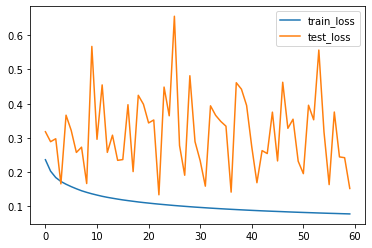

In [85]:
#plotting how the losses go for the epochs
plt.plot(train_losses,label="train_loss")
plt.plot(test_losses,label="test_loss")
plt.legend()

In [95]:
#save the model
torch.save(model,"face")

In [258]:
#load the model
model=torch.load("face")

In [153]:
#checking the accuracy for the train_set
count=0
 #i used a distance paramater=0.8 if the distance is less than 0.8 it is a match else it is not
dist1=[]
for i in range(len(train_positive)):
    x1=load_img(train_positive[i][0])/255
    x2=load_img(train_positive[i][1])/255
    d=predict(x1,x2)
    dist1.append(d[0])
    #if distance is less than 0.8 you increment the count
    if(d[0]<0.8):
        count+=1
#and you divide the count with total length to get accuracy and it is also similary done for negative samples
pos=count/len(train_positive)
count=0
size=len(train_positive)
neg_indices = np.random.choice(len(train_negative), size=size, replace=False)
dist2=[]
for i in neg_indices:
    x1=load_img(train_negative[i][0])/255
    x2=load_img(train_negative[i][1])/255
    x1=x1.reshape(1,1,60,80)
    x2=x2.reshape(1,1,60,80)
    d=predict(x1,x2)
    dist2.append(d[0])
    if(d[0]>0.8):
        count+=1
neg=count/size
acc=((pos+neg)/2)*100
print(f"train accuracy:{acc:.2f}")

train accuracy:90.83


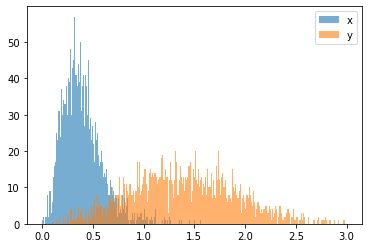

In [116]:
#distances split b/w train_positve and train_negative
bins = np.linspace(0, 3, 450)
plt.hist(dist1, bins, alpha=0.6, label='x')
plt.hist(dist2, bins, alpha=0.6, label='y')
plt.legend(loc='upper right')
plt.show()

In [180]:
#checking the accuracy for the test_set
count1=0
dist1=[]
for i in range(len(test_positive)):
    x1=load_img(test_positive[i][0])/255
    x2=load_img(test_positive[i][1])/255
    d=predict(x1,x2)
    if(d[0]<0.8):
        count1+=1
    dist1.append(d[0])
pos=count1/len(test_positive)
dist2=[]
count=0
size=len(test_positive)
neg_indices = np.random.choice(len(test_negative), size=size, replace=False)
for i in neg_indices:
    x1=load_img(test_negative[i][0])/255
    x2=load_img(test_negative[i][1])/255
    d=predict(x1,x2)
    if(d[0]>0.8):
        count+=1
    dist2.append(d[0])
neg=count/size
acc=((pos+neg)/2)*100
print(f"test accuracy:{acc:.2f}")

test accuracy:78.83


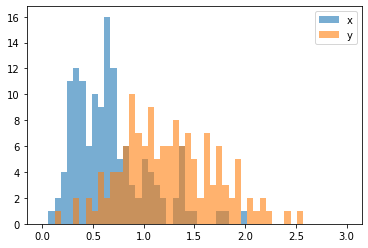

In [181]:
#distances split b/w test_positve and test_negative
bins = np.linspace(0, 3, 50)
plt.hist(dist1, bins, alpha=0.6, label='x')
plt.hist(dist2, bins, alpha=0.6, label='y')
plt.legend(loc='upper right')
plt.show()

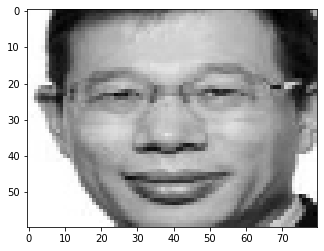

In [277]:
#testing for a random image in the positive set 
k=np.random.choice(len(test_positive), size=1, replace=False)[0]
#loading the passport photo
im1=load_img(test_positive[k][0])/255
plt.imshow(im1,cmap="gray")

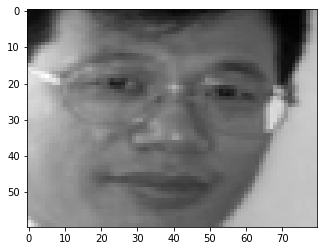

In [278]:
#loading the selfie
im2=load_img(test_positive[k][1])/255
plt.imshow(im2,cmap="gray")

In [280]:
#load the model
d=predict(im1,im2)
if(d[0]<0.8):
        print("it's a match")

it's a match


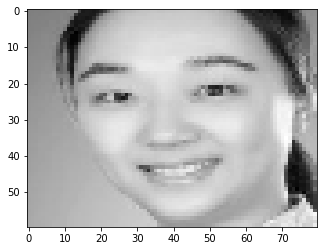

In [251]:
#testing for a random image in the negative set 
k=np.random.choice(len(test_negative), size=1, replace=False)[0]
#loading the passport size photo
im1=load_img(test_negative[k][0])/255
plt.imshow(im1,cmap="gray")

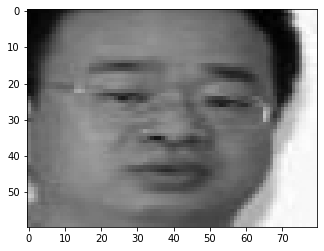

In [252]:
#loading the selfie
im2=load_img(test_negative[k][1])/255
plt.imshow(im2,cmap="gray")

In [259]:
#testing for the above two images
d=predict(im1,im2)
if(d[0]>0.8):
        print("no match")

no match
